In [1]:
import scipy.stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

from matplotlib import rcParams
rcParams['font.family'] = 'DejaVu Serif'

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

# Downstream Tasks Metrics

In [24]:
import os
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def _safe_filename(s: str) -> str:
    return re.sub(r'[\\/:*?"<>|]', '-', str(s)).strip()


def _save_fig(
    fig,
    analysis,
    title_suffix,
    dataset_name,
    save_root="Plot",
    dpi=300,
    gen_label=None,
):
    if dataset_name is None or title_suffix is None:
        return

    kind = {"pca": "PCA", "tsne": "t-SNE", "kernel": "CDF"}[analysis]
    ds = _safe_filename(dataset_name)
    suf = _safe_filename(title_suffix)
    glb = _safe_filename(gen_label) if gen_label else None

    out_dir = os.path.join(save_root, ds)
    os.makedirs(out_dir, exist_ok=True)

    fname = f"{suf} {kind}" + (f" {glb}" if glb else "") + ".png"
    out_path = os.path.join(out_dir, fname)

    fig.savefig(out_path, dpi=dpi, bbox_inches="tight", pad_inches=0.1)


def visualization(
    ori_data,
    generated_data,
    analysis,
    compare=1000,
    ori_label="Original",
    gen_label="Synthetic",
    title_suffix="Overall Generation",
    dataset_name=None,
    save_root="Plot",
    save_dpi=300,
):
    """Using PCA or tSNE or Kernel Density for visualization."""
    anal_sample_no = min([compare, ori_data.shape[0]])
    idx = np.random.permutation(ori_data.shape[0])[:anal_sample_no]

    ori_data = ori_data[idx]
    generated_data = generated_data[idx]

    no, seq_len, dim = ori_data.shape

    for i in range(anal_sample_no):
        if i == 0:
            prep_data = np.reshape(np.mean(ori_data[0, :, :], 1), [1, seq_len])
            prep_data_hat = np.reshape(np.mean(generated_data[0, :, :], 1), [1, seq_len])
        else:
            prep_data = np.concatenate(
                (prep_data, np.reshape(np.mean(ori_data[i, :, :], 1), [1, seq_len]))
            )
            prep_data_hat = np.concatenate(
                (prep_data_hat, np.reshape(np.mean(generated_data[i, :, :], 1), [1, seq_len]))
            )

    colors = ["red"] * anal_sample_no + ["blue"] * anal_sample_no


    if analysis == "tsne":
        # t-SNE
        prep_data_final = np.concatenate((prep_data, prep_data_hat), axis=0)
        tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
        tsne_results = tsne.fit_transform(prep_data_final)

        f, ax = plt.subplots(1)
        plt.scatter(
            tsne_results[:anal_sample_no, 0],
            tsne_results[:anal_sample_no, 1],
            c=colors[:anal_sample_no],
            alpha=0.2,
            label=ori_label,
        )
        plt.scatter(
            tsne_results[anal_sample_no:, 0],
            tsne_results[anal_sample_no:, 1],
            c=colors[anal_sample_no:],
            alpha=0.2,
            label=gen_label,
        )

        ax.legend(loc="upper right", bbox_to_anchor=(1.05, 1.05), fontsize=20)
        #plt.ylim(-25,25)
        plt.title(f"t-SNE {title_suffix}", fontsize=25)
        ax.tick_params(axis="both", which="major", labelsize=25)

        _save_fig(
            f,
            "tsne",
            title_suffix,
            dataset_name,
            save_root,
            dpi=save_dpi,
            gen_label=gen_label,
        )
        plt.show()

    elif analysis == "kernel":
        f, ax = plt.subplots(1)
        sns.kdeplot(prep_data.flatten(), linewidth=3, label=ori_label, color="red")
        sns.kdeplot(
            prep_data_hat.flatten(),
            linewidth=3,
            linestyle="--",
            label=gen_label,
            color="blue",
        )

        ax.legend(loc="upper right", bbox_to_anchor=(1.05, 1.05), fontsize=20)
        #plt.ylim(0,5)
        plt.title(f"CDF {title_suffix}", fontsize=25)
        plt.xlabel("Data Value", fontsize=30)
        plt.ylabel("Density", fontsize=30)
        ax.tick_params(axis="both", which="major", labelsize=25)

        _save_fig(
            f,
            "kernel",
            title_suffix,
            dataset_name,
            save_root,
            dpi=save_dpi,
            gen_label=gen_label,
        )
        plt.show()
        plt.close()


## predictive score

In [3]:

import torch
from torch import nn, optim
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm


def extract_time(data):
    """Returns Maximum sequence length and each sequence length."""
    time = []
    max_seq_len = 0
    for i in range(len(data)):
        seq_len = len(data[i][:, 0])
        time.append(seq_len)
        max_seq_len = max(max_seq_len, seq_len)
    return time, max_seq_len


# ✅ GRU Predictor
class GRUPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GRUPredictor, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        packed_input = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.gru(packed_input)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        y_hat = self.sigmoid(self.fc(output))
        return y_hat


# ✅ Predictive Score Function
def predictive_score_metrics_pytorch(ori_data, generated_data, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Train a GRU on generated_data (one-step-ahead prediction),
    then evaluate it on ori_data to compute MAE.
    """
    ori_time, _ = extract_time(ori_data)
    gen_time, _ = extract_time(generated_data)

    no, seq_len, dim = ori_data.shape
    hidden_dim = max(1, dim // 2)
    output_dim = dim
    input_dim = dim
    iterations = 5000
    batch_size = 128

    model = GRUPredictor(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(device)
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters())

    # --- Training ---
    model.train()
    for _ in tqdm(range(iterations), desc='Training Predictor'):
        idx = np.random.permutation(len(generated_data))[:batch_size]
        X_mb = [generated_data[i][:-1, :] for i in idx]
        Y_mb = [generated_data[i][1:, :] for i in idx]
        T_mb = [gen_time[i] - 1 for i in idx]

        lengths = torch.tensor(T_mb).to(device)
        X_tensor = torch.nn.utils.rnn.pad_sequence([torch.tensor(x, dtype=torch.float32) for x in X_mb], batch_first=True).to(device)
        Y_tensor = torch.nn.utils.rnn.pad_sequence([torch.tensor(y, dtype=torch.float32) for y in Y_mb], batch_first=True).to(device)

        optimizer.zero_grad()
        y_hat = model(X_tensor, lengths)
        loss = criterion(y_hat, Y_tensor)
        loss.backward()
        optimizer.step()

    # --- Evaluation ---
    model.eval()
    with torch.no_grad():
        idx = np.random.permutation(len(ori_data))[:no]
        X_mb = [ori_data[i][:-1, :] for i in idx]
        Y_mb = [ori_data[i][1:, :] for i in idx]
        T_mb = [ori_time[i] - 1 for i in idx]

        lengths = torch.tensor(T_mb).to(device)
        X_tensor = torch.nn.utils.rnn.pad_sequence([torch.tensor(x, dtype=torch.float32) for x in X_mb], batch_first=True).to(device)
        y_hat = model(X_tensor, lengths).cpu()

    # --- MAE Score ---
    total_mae = 0
    for i in range(no):
        pred_seq_len = len(Y_mb[i])
        total_mae += mean_absolute_error(Y_mb[i], y_hat[i, :pred_seq_len].numpy())

    predictive_score = total_mae / no
    return predictive_score

## Context_FID 

In [19]:
import scipy
import numpy as np

from ts2vec.ts2vec import TS2Vec


def calculate_fid(act1, act2):
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def Context_FID(ori_data, generated_data):
    model = TS2Vec(input_dims=ori_data.shape[-1], device=0, batch_size=8, lr=0.001, output_dims=320,
                   max_train_length=3000)
    model.fit(ori_data, verbose=False)
    ori_represenation = model.encode(ori_data, encoding_window='full_series')
    gen_represenation = model.encode(generated_data, encoding_window='full_series')
    idx = np.random.permutation(ori_data.shape[0])
    ori_represenation = ori_represenation[idx]
    gen_represenation = gen_represenation[idx]
    results = calculate_fid(ori_represenation, gen_represenation)
    return results



# Distribution Metrics

In [5]:
import numpy as np

def wasserstein_1d(p_samples: np.ndarray, q_samples: np.ndarray) -> float:
    p = np.sort(np.asarray(p_samples).ravel())
    q = np.sort(np.asarray(q_samples).ravel())
    n, m = len(p), len(q)
    L = min(n, m)
    p_idx = (np.linspace(0, n - 1, L)).astype(int)
    q_idx = (np.linspace(0, m - 1, L)).astype(int)
    return float(np.mean(np.abs(p[p_idx] - q[q_idx])))


def _hist_pdf(x, bins=64, range_=None, eps=1e-12):
    if range_ is None:
        xmin = np.min(x)
        xmax = np.max(x)
        if xmin == xmax:
            xmin -= 0.5
            xmax += 0.5
        range_ = (xmin, xmax)
    hist, edges = np.histogram(x, bins=bins, range=range_, density=False)
    prob = hist.astype(float)
    prob = prob / max(prob.sum(), 1.0)
    prob = (prob + eps) / (prob.sum() + eps * len(prob))
    return prob, edges


def _match_hist_pdf(x, edges, eps=1e-12):
    hist, _ = np.histogram(x, bins=edges, density=False)
    prob = hist.astype(float)
    prob = prob / max(prob.sum(), 1.0)
    prob = (prob + eps) / (prob.sum() + eps * len(prob))
    return prob


def kl_divergence(p_samples: np.ndarray, q_samples: np.ndarray, bins: int = 64) -> float:
    p = np.asarray(p_samples).ravel()
    q = np.asarray(q_samples).ravel()
    p_pdf, edges = _hist_pdf(p, bins=bins)
    q_pdf = _match_hist_pdf(q, edges)
    return float(np.sum(p_pdf * (np.log(p_pdf) - np.log(q_pdf))))


def js_divergence(p_samples: np.ndarray, q_samples: np.ndarray, bins: int = 64) -> float:
    p = np.asarray(p_samples).ravel()
    q = np.asarray(q_samples).ravel()
    p_pdf, edges = _hist_pdf(p, bins=bins)
    q_pdf = _match_hist_pdf(q, edges)
    m = 0.5 * (p_pdf + q_pdf)
    kl_pm = np.sum(p_pdf * (np.log(p_pdf) - np.log(m)))
    kl_qm = np.sum(q_pdf * (np.log(q_pdf) - np.log(m)))
    return float(0.5 * (kl_pm + kl_qm))


def crps_p_vs_q(p_samples: np.ndarray, q_samples: np.ndarray, max_pairs: int = 200000) -> float:
    p = np.asarray(p_samples).ravel()
    q = np.asarray(q_samples).ravel()

    n = len(p)
    m = len(q)

    pairs_xy = min(max_pairs, n * m)
    idx_p = np.random.randint(0, n, size=pairs_xy)
    idx_q = np.random.randint(0, m, size=pairs_xy)
    term_xy = np.abs(q[idx_q] - p[idx_p]).mean()

    pairs_xx = min(max_pairs, m * m)
    idx_q1 = np.random.randint(0, m, size=pairs_xx)
    idx_q2 = np.random.randint(0, m, size=pairs_xx)
    term_xx = np.abs(q[idx_q1] - q[idx_q2]).mean()

    return float(term_xy - 0.5 * term_xx)


# Extract Extreme

In [7]:
def extract_top_percent_blocks_keep_shape(X: np.ndarray, percent: float = 0.1) -> np.ndarray:
    M, N, _ = X.shape
    newN = max(1, int(np.ceil(N * percent)))

    selected_blocks = []
    for i in range(M):
        block = X[i, :, 0] 
        block_sorted = np.sort(block)[::-1] 
        topk = block_sorted[:newN]
        selected_blocks.append(topk.reshape(-1, 1))  

    selected = np.stack(selected_blocks, axis=0) 
    return selected

# Read Dataset

In [9]:
keyword = 'stock' # put the dataset name here

gendata = np.load(f'OUTPUT/{keyword}(5)/ddpm_fake_{keyword}.npy')
oridata = np.load(f'OUTPUT/stock(5)/samples/{keyword}_norm_truth_24_train.npy')

In [11]:
gendata1 = extract_top_percent_blocks_keep_shape(gendata,percent = 0.1)
oridata1 = extract_top_percent_blocks_keep_shape(oridata,percent = 0.1)

In [13]:
import numpy as np
import torch

def calculate_the_downstream_metrics(oriData,genData):
    pred = predictive_score_metrics_pytorch(oriData, genData)
    fid = Context_FID(oriData, genData)
    
    print(f"Avg Predictive Score     : {pred:.8f}")
    print(f"Avg Context FID          : {fid:.8f}")

In [16]:
def calculate_distribution_metrics(oriData, genData):
    real_flat = oriData.reshape(-1)
    gen_flat = genData.reshape(-1)

    wass = wasserstein_1d(real_flat, gen_flat)
    kl   = kl_divergence(real_flat, gen_flat)
    js   = js_divergence(real_flat, gen_flat)
    crps = crps_p_vs_q(real_flat, gen_flat)

    print(f"KL Divergence        : {kl:.8f}")
    print(f"JS Divergence        : {js:.8f}")
    print(f"Wasserstein Distance : {wass:.8f}")
    print(f"CRPS                 : {crps:.8f}")

# Evaluation for Extreme Distribution

In [17]:
calculate_distribution_metrics(oridata1,gendata1)

KL Divergence        : 0.19432631
JS Divergence        : 0.04246504
Wasserstein Distance : 0.03687520
CRPS                 : 0.13957013


# Evaluation for Overall Distribution

In [20]:
calculate_distribution_metrics(oridata,gendata)
calculate_the_downstream_metrics(oridata,gendata)

Training Predictor: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:21<00:00, 229.92it/s]


Avg Predictive Score     : 0.14658860
Avg Context FID          : 0.04035303
KL Divergence        : 0.14342213
JS Divergence        : 0.03009532
Wasserstein Distance : 0.03448482
CRPS                 : 0.13540826


# Visualization for Origin Distribution

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.284s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.025427
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.965542
[t-SNE] KL divergence after 300 iterations: 0.635733


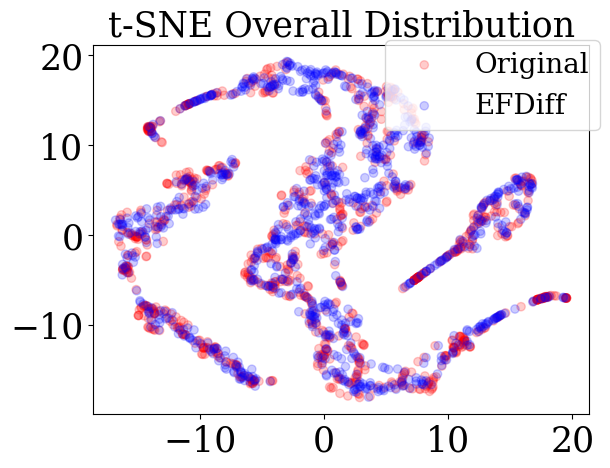

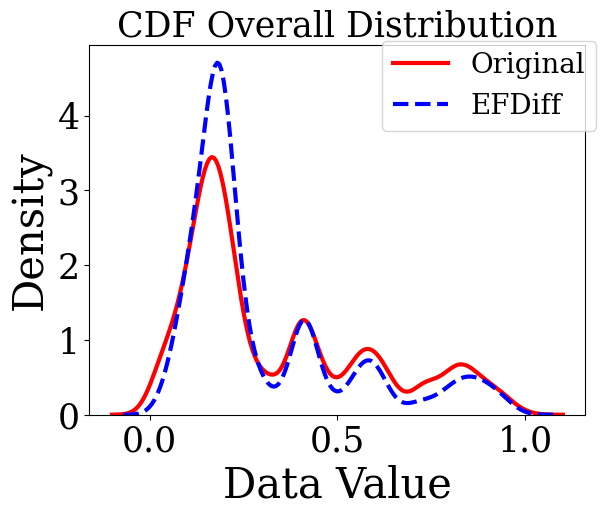

In [25]:
visualization(oridata,gendata,'tsne',ori_label="Original", gen_label="EFDiff",title_suffix="Overall Distribution",dataset_name= keyword)
visualization(oridata,gendata,'kernel',ori_label="Original", gen_label="EFDiff",title_suffix="Overall Distribution",dataset_name= keyword)